# **Final project: the "1C" competition**
This challenge serves as final project for the "How to win a data science competition" Coursera course.

In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company.

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

## File descriptions




*  sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.

*   test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.

*   sample_submission.csv - a sample submission file in the correct format.
items.csv - supplemental information about the items/products.

*  item_categories.csv - supplemental information about the items categories.


*   shops.csv- supplemental information about the shops.




## Data fields


*   ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

# EDA

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import seaborn as sns
import string
import time
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor 
import gc

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

from itertools import product
%matplotlib inline

In [2]:
sales = pd.read_csv('../input/sales_train.csv')
items = pd.read_csv('../input/items.csv')
shops = pd.read_csv('../input/shops.csv')
item_cats = pd.read_csv('../input/item_categories.csv')
test  = pd.read_csv('../input/test.csv').set_index('ID')

In [3]:
print("----------Top-5- Record----------")
print(sales.head(5))
print("-----------Information-----------")
print(sales.info())
print("-----------Data Types-----------")
print(sales.dtypes)
print("----------Missing value-----------")
print(sales.isnull().sum())
print("----------Null value-----------")
print(sales.isna().sum())
print("----------Shape of Data----------")
print(sales.shape)

----------Top-5- Record----------
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
-----------Data Types-----------
date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        flo

check duplicated rows 

In [4]:
print('Number of duplicates:', len(sales[sales.duplicated()]))

Number of duplicates: 6


not worthy of investigation  as the number of rows is 6 

In [5]:
sales["revenue"] = sales["item_price"] * sales["item_cnt_day"]

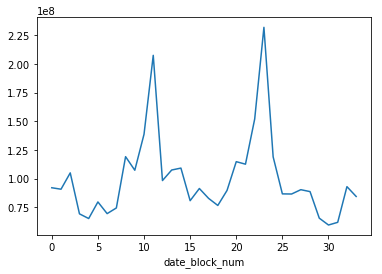

In [6]:
#many 1c products are seasonal and probably release date depended.as expected 
sales.groupby("date_block_num")["revenue"].sum().plot()

**Outliers by price and sales volume**

Sale volume outliers: [ 8057 20949  9242 19437  3731 11373  9249  9248]
Item price outliers: [11365  6066 13199]


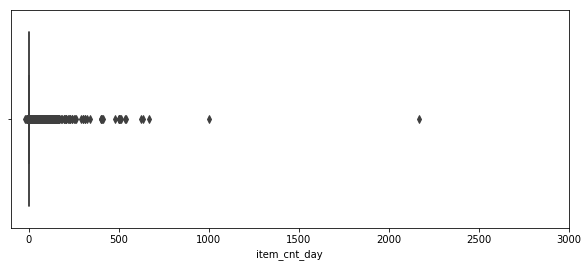

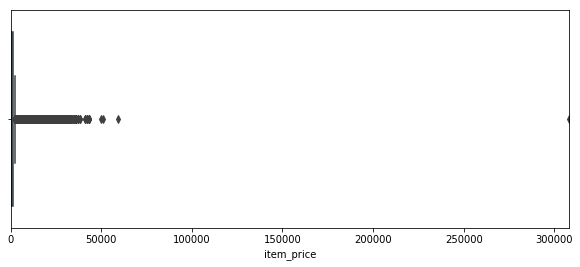

In [7]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=sales['item_cnt_day'])
print('Sale volume outliers:',sales['item_id'][sales['item_cnt_day']>500].unique())

plt.figure(figsize=(10,4))
plt.xlim(sales['item_price'].min(), sales['item_price'].max())
sns.boxplot(x=sales['item_price'])
print('Item price outliers:',sales['item_id'][sales['item_price']>50000].unique())

In [8]:
sales = sales[(sales.item_price<90000) & (sales.item_price > 0)]
sales = sales[sales.item_cnt_day<900]

# Preprocessing and Feature Engineering

In [9]:
# Translate the item category name and find meta category, subtype
symbols=(u"абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ", u"abvgdeejzijklmnoprstufhzcss_y_euaABVGDEEJZIJKLMNOPRSTUFHZCSS_Y_EUA")
english = {ord(a):ord(b) for a, b in zip(*symbols)}

item_cats['items_english'] = item_cats['item_category_name'].apply(lambda x: x.translate(english))
item_cats['meta_category'] = item_cats['items_english'].apply(lambda x: x.split('-')[0])
item_cats['subtype'] = item_cats['items_english'].apply(lambda x: x.split('-')) \
                                                             .map(lambda x:x[1].strip() if len(x)>1 else x[0].strip())
item_cats.head()

,item_category_name,item_category_id,items_english,meta_category,subtype
0,PC - Гарнитуры/Наушники,0,PC - Garnitury/Nausniki,PC,Garnitury/Nausniki
1,Аксессуары - PS2,1,Aksessuary - PS2,Aksessuary,PS2
2,Аксессуары - PS3,2,Aksessuary - PS3,Aksessuary,PS3
3,Аксессуары - PS4,3,Aksessuary - PS4,Aksessuary,PS4
4,Аксессуары - PSP,4,Aksessuary - PSP,Aksessuary,PSP


In [10]:
item_cats['meta_category'].value_counts()

Knigi                                13
Podarki                              12
Igry                                  8
Igrovye konsoli                       8
Aksessuary                            7
Muzyka                                6
Programmy                             6
Kino                                  5
Igry PC                               4
Karty oplaty                          4
Cistye nositeli (stucnye)             1
Karty oplaty (Kino, Muzyka, Igry)     1
Dostavka tovara                       1
Igry Android                          1
Cistye nositeli (spil_)               1
Bilety (Zifra)                        1
Slujebnye                             1
Igry MAC                              1
Slujebnye                             1
PC                                    1
Elementy pitania                      1
Name: meta_category, dtype: int64

In [11]:
item_cats['subtype'].value_counts()

Zifra                                4
PSVita                               3
PSP                                  3
PS4                                  3
XBOX ONE                             3
PS3                                  3
Blu                                  3
PS2                                  3
XBOX 360                             3
Hudojestvennaa literatura            1
CD lokal_nogo proizvodstva           1
Garnitury/Nausniki                   1
Nastol_nye igry (kompaktnye)         1
Komp_uternaa literatura              1
Artbuki, enziklopedii                1
Gadjety, roboty, sport               1
Muzykal_noe video                    1
Suveniry (v navesku)                 1
Magkie igruski                       1
Audioknigi 1S                        1
Poznavatel_naa literatura            1
Live! (Zifra)                        1
Standartnye izdania                  1
Kollekzionnye izdania                1
Aksessuary dla igr                   1
Biznes literatura        

In [12]:
# Label encoding
labelencoder = LabelEncoder()
item_cats["meta_category_code"] = labelencoder.fit_transform(item_cats["meta_category"])
item_cats["subtype_code"] = labelencoder.fit_transform(item_cats["subtype"])
item_cats = item_cats.drop(["items_english", "meta_category", "subtype"], axis=1)

In [13]:
item_cats.head()


,item_category_name,item_category_id,meta_category_code,subtype_code
0,PC - Гарнитуры/Наушники,0,16,23
1,Аксессуары - PS2,1,0,43
2,Аксессуары - PS3,2,0,44
3,Аксессуары - PS4,3,0,45
4,Аксессуары - PSP,4,0,47


In [14]:
# Translate the shop name and find towns
shops["shops_english"] = shops["shop_name"].apply(lambda x: x.translate(english))
shops["town"] = shops["shops_english"].apply(lambda x: x.split()[0])
shops.head()

,shop_name,shop_id,shops_english,town
0,"!Якутск Орджоникидзе, 56 фран",0,"!Akutsk Ordjonikidze, 56 fran",!Akutsk
1,"!Якутск ТЦ ""Центральный"" фран",1,"!Akutsk TZ ""Zentral_nyj"" fran",!Akutsk
2,"Адыгея ТЦ ""Мега""",2,"Adygea TZ ""Mega""",Adygea
3,"Балашиха ТРК ""Октябрь-Киномир""",3,"Balasiha TRK ""Oktabr_-Kinomir""",Balasiha
4,"Волжский ТЦ ""Волга Молл""",4,"Voljskij TZ ""Volga Moll""",Voljskij


In [15]:
shops['town_cleaned'] = shops['town'].str.replace(r'[^\w\s]+', '')

In [16]:
shops['town_cleaned'].unique()

array(['Akutsk', 'Adygea', 'Balasiha', 'Voljskij', 'Vologda', 'Voronej',
       'Vyezdnaa', 'Jukovskij', 'Internetmagazin', 'Kazan_', 'Kaluga',
       'Kolomna', 'Krasnoarsk', 'Kursk', 'Moskva', 'Mytisi', 'NNovgorod',
       'Novosibirsk', 'Omsk', 'RostovNaDonu', 'SPb', 'Samara', 'Sergiev',
       'Surgut', 'Tomsk', 'Tumen_', 'Ufa', 'Himki', 'Zifrovoj', 'Cehov',
       'Aroslavl_'], dtype=object)

In [17]:
shop_groups = shops['shops_english'].groupby(shops['town_cleaned'])

In [18]:
for i,gr in shop_groups : print(i,"\n" ,gr ,"\n")

Adygea 
 2    Adygea TZ "Mega"
Name: shops_english, dtype: object 

Akutsk 
 0     !Akutsk Ordjonikidze, 56 fran
1     !Akutsk TZ "Zentral_nyj" fran
57          Akutsk Ordjonikidze, 56
58          Akutsk TZ "Zentral_nyj"
Name: shops_english, dtype: object 

Aroslavl_ 
 59    Aroslavl_ TZ "Al_tair"
Name: shops_english, dtype: object 

Balasiha 
 3    Balasiha TRK "Oktabr_-Kinomir"
Name: shops_english, dtype: object 

Cehov 
 56    Cehov TRZ "Karnaval"
Name: shops_english, dtype: object 

Himki 
 54    Himki TZ "Mega"
Name: shops_english, dtype: object 

Internetmagazin 
 12    Internet-magazin CS
Name: shops_english, dtype: object 

Jukovskij 
 10    Jukovskij ul. Ckalova 39m?
11    Jukovskij ul. Ckalova 39m²
Name: shops_english, dtype: object 

Kaluga 
 15    Kaluga TRZ "XXI vek"
Name: shops_english, dtype: object 

Kazan_ 
 13        Kazan_ TZ "Behetle"
14    Kazan_ TZ "ParkHaus" II
Name: shops_english, dtype: object 

Kolomna 
 16    Kolomna TZ "Rio"
Name: shops_english, dtype: objec

merging  duplicate shops

In [19]:
#Akutsk Ordjonikidze,
sales.loc[sales.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

#Akutsk TZ "Zentral_nyj"
sales.loc[sales.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

#Jukovskij ul. Ckalova 39m
sales.loc[sales.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [20]:
# shops Label encoding
shops["town_code"] = labelencoder.fit_transform(shops["town_cleaned"])
shops = shops.drop(["shops_english", "town","town_cleaned"], axis=1)

In [21]:
shops.head()

,shop_name,shop_id,town_code
0,"!Якутск Орджоникидзе, 56 фран",0,1
1,"!Якутск ТЦ ""Центральный"" фран",1,1
2,"Адыгея ТЦ ""Мега""",2,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,3
4,"Волжский ТЦ ""Волга Молл""",4,26


In [22]:
sales['date'][:2]

0    02.01.2013
1    03.01.2013
Name: date, dtype: object

In [23]:
'''
sales['date'] = pd.to_datetime(sales['date'] ,format = "%d.%m.%Y")
sales['day'] = sales['date'].dt.day
sales['week'] = sales['date'].dt.week
sales['month'] = sales['date'].dt.month
sales['year'] = sales['date'].dt.year
'''

'\nsales[\'date\'] = pd.to_datetime(sales[\'date\'] ,format = "%d.%m.%Y")\nsales[\'day\'] = sales[\'date\'].dt.day\nsales[\'week\'] = sales[\'date\'].dt.week\nsales[\'month\'] = sales[\'date\'].dt.month\nsales[\'year\'] = sales[\'date\'].dt.year\n'

In [24]:
# Create "grid" with columns
index_cols = ['date_block_num','shop_id','item_id']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[[block_num] ,cur_shops, cur_items])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)


In [25]:
grid.head()

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564


In [26]:
grid.sort_values(index_cols,inplace=True)

In [27]:
# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [28]:
gb.head()

,date_block_num,shop_id,item_id,item_cnt_day
,,,,target
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0


In [29]:
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
gb.head()

,date_block_num,shop_id,item_id,target
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0


In [30]:
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols)
all_data ['target'] = all_data ['target'].fillna(0).clip(0,20).astype('float16')

In [31]:
del grid, gb 
gc.collect();

In [32]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10913804 entries, 0 to 10913803
Data columns (total 4 columns):
date_block_num    int32
shop_id           int32
item_id           int32
target            float16
dtypes: float16(1), int32(3)
memory usage: 229.0 MB


In [33]:
#downcasting data to save memory 
all_data['shop_id'] = all_data['shop_id'].astype(np.int8)
all_data['item_id'] = all_data['item_id'].astype(np.int16)
all_data['date_block_num'] = all_data['date_block_num'].astype(np.int8)

In [34]:
# Save `date_block_num` 
dates = all_data['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [35]:
test['date_block_num'] = last_block + 1
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test['date_block_num'] = test['date_block_num'].astype(np.int8)

In [36]:
all_data = pd.concat([all_data, test], ignore_index=True, sort=False, keys=index_cols)
all_data.fillna(0, inplace=True) # fill empty  month 34 of test set

In [37]:
all_data = pd.merge(all_data, shops, on=['shop_id'], how='left')
all_data = pd.merge(all_data, items, on=['item_id'], how='left')
all_data = pd.merge(all_data, item_cats, on=['item_category_id'], how='left')

In [38]:
all_data['town_code'] = all_data['town_code'].astype(np.int8)
all_data['item_category_id'] = all_data['item_category_id'].astype(np.int8)
all_data['meta_category_code'] = all_data['meta_category_code'].astype(np.int8)
all_data['subtype_code'] = all_data['subtype_code'].astype(np.int8)

In [39]:
all_data.head()

,date_block_num,shop_id,item_id,target,shop_name,town_code,item_name,item_category_id,item_category_name,meta_category_code,subtype_code
0,0,2,19,0.0,"Адыгея ТЦ ""Мега""",0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,Кино - DVD,13,15
1,0,2,27,1.0,"Адыгея ТЦ ""Мега""",0,"007 Legends [PS3, русская версия]",19,Игры - PS3,7,44
2,0,2,28,0.0,"Адыгея ТЦ ""Мега""",0,"007 Legends [PС, Jewel, русская версия]",30,Игры PC - Стандартные издания,10,56
3,0,2,29,0.0,"Адыгея ТЦ ""Мега""",0,"007 Legends [Xbox 360, русская версия]",23,Игры - XBOX 360,7,62
4,0,2,32,0.0,"Адыгея ТЦ ""Мега""",0,1+1,40,Кино - DVD,13,15


In [40]:
all_data.drop(['item_name' ,'shop_name' ,'item_category_name'] ,axis= 1 , inplace = True)

In [41]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 8 columns):
date_block_num        int8
shop_id               int8
item_id               int16
target                float16
town_code             int8
item_category_id      int8
meta_category_code    int8
subtype_code          int8
dtypes: float16(1), int16(1), int8(6)
memory usage: 191.0 MB


# Mean Encdoing and Target Lags

In [42]:
#  lags features (shift to mimic future values)
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [43]:
# Make lag features for monthly count (target) , using expanding mean ecndoing regularizing technique 
def expanding_mean_encoding(all_data, cols, name, lags):
    a = all_data.copy()
    cumsum = a.groupby(cols)['target'].cumsum() - a['target']
    cumcnt = a.groupby(cols).cumcount()
    a[name] = cumsum/cumcnt
    
    a[name] = a.groupby(cols)[name].transform(lambda x: x.fillna(x.mean()))
    a[name] = a[name].astype(np.float32)
    a = lag_feature(a, lags, name)
    a.drop([name], axis=1, inplace=True)
    return a

In [44]:
def KFoldScheme_mean_encoding(all_data, cols, name, lags):
    a = all_data.copy()
    kf = model_selection.KFold(5, shuffle=False)
    a[name] = 0

    for tr_ind, val_ind in kf.split(all_data):
        X_tr, X_val = a.iloc[tr_ind], a.iloc[val_ind]
        grp = X_tr.groupby(cols).target.mean()
        grp2 = X_val.set_index(cols).index
        a.loc[a.index[val_ind],name] = grp2.map(grp)

    a[name] = a[name].astype(np.float16)
    a = lag_feature(a, lags, name)
    a.drop([name], axis=1, inplace=True)
    return a

In [45]:
# Make lag encoded features for item_cnt_month
def mean_encoding_lag(matrix, cols, name, lags):
    a = matrix.copy()
    group = a.groupby(cols).agg({'target': ['mean']})
    group.columns = [name]
    group.reset_index(inplace=True)

    a = pd.merge(a, group, on=cols, how='left')
    a[name] = a[name].astype(np.float16)
    a = lag_feature(a, lags, name)
    a.drop([name], axis=1, inplace=True)
    return a

In [46]:
all_data['target'] = all_data['target'].astype(np.float16)

In [47]:
%%time
all_data = lag_feature(all_data, [1,2,3,6,12], 'target')

CPU times: user 40.5 s, sys: 9.57 s, total: 50.1 s
Wall time: 50.2 s


In [48]:
%%time
all_data = KFoldScheme_mean_encoding(all_data, ['date_block_num'], 'date_avg_item_cnt', [1])

CPU times: user 15.5 s, sys: 5.86 s, total: 21.4 s
Wall time: 21.4 s


In [49]:
%%time
all_data = KFoldScheme_mean_encoding(all_data, ['date_block_num', 'item_id'], 'date_item_avg_item_cnt', [1,2,3,6,12])

CPU times: user 1min 21s, sys: 17.3 s, total: 1min 38s
Wall time: 1min 38s


In [50]:
%%time
all_data = KFoldScheme_mean_encoding(all_data, ['date_block_num', 'shop_id'], 'date_shop_avg_item_cnt', [1,2,3,6,12])


CPU times: user 1min 18s, sys: 19.4 s, total: 1min 38s
Wall time: 1min 38s


In [51]:
%%time
all_data = KFoldScheme_mean_encoding(all_data, ['date_block_num', 'item_category_id'], 'date_category_avg_item_cnt', [1])

CPU times: user 44.4 s, sys: 11.2 s, total: 55.6 s
Wall time: 55.6 s


In [52]:
%%time
all_data = KFoldScheme_mean_encoding(all_data, ['date_block_num', 'shop_id', 'item_category_id'], 'date_shop_category_avg_item_cnt', [1])


CPU times: user 49.3 s, sys: 11.8 s, total: 1min 1s
Wall time: 1min 1s


In [53]:
%%time
all_data = KFoldScheme_mean_encoding(all_data, ['date_block_num', 'shop_id', 'meta_category_code'], 'date_shop_meta_category_avg_item_cnt', [1])


CPU times: user 49.8 s, sys: 13 s, total: 1min 2s
Wall time: 1min 2s


In [54]:
%%time
all_data = KFoldScheme_mean_encoding(all_data, ['date_block_num', 'shop_id', 'subtype_code'], 'date_shop_subtype_avg_item_cnt', [1])


CPU times: user 50.2 s, sys: 13.1 s, total: 1min 3s
Wall time: 1min 3s


In [55]:
%%time
all_data = KFoldScheme_mean_encoding(all_data, ['date_block_num', 'town_code'], 'date_town_avg_item_cnt', [1])
gc.collect();

CPU times: user 45.2 s, sys: 13.4 s, total: 58.6 s
Wall time: 58.6 s


In [56]:
%%time
all_data = KFoldScheme_mean_encoding(all_data, ['date_block_num', 'item_id', 'town_code'], 'date_item_town_avg_item_cnt', [1])


CPU times: user 1min 13s, sys: 16.1 s, total: 1min 29s
Wall time: 1min 29s


In [57]:
%%time
all_data = KFoldScheme_mean_encoding(all_data, ['date_block_num', 'meta_category_code'], 'date_meta_category_avg_item_cnt', [1])


CPU times: user 45.4 s, sys: 12.5 s, total: 57.9 s
Wall time: 57.9 s


In [58]:
%%time
all_data = KFoldScheme_mean_encoding(all_data, ['date_block_num', 'subtype_code'], 'date_subtype_avg_item_cnt', [1])



CPU times: user 46.4 s, sys: 14.3 s, total: 1min
Wall time: 1min


In [59]:
gc.collect();
all_data.head()

,date_block_num,shop_id,item_id,target,town_code,item_category_id,meta_category_code,subtype_code,target_lag_1,target_lag_2,target_lag_3,target_lag_6,target_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_category_avg_item_cnt_lag_1,date_shop_category_avg_item_cnt_lag_1,date_shop_meta_category_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_town_avg_item_cnt_lag_1,date_item_town_avg_item_cnt_lag_1,date_meta_category_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1
0,0,2,19,0.0,0,40,13,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,7,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,10,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,7,62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,13,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
all_data['month'] = all_data['date_block_num'] % 12

In [61]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
all_data['days'] = all_data['month'].map(days).astype(np.int8)

In [62]:
all_data['item_shop_first_sale'] = all_data['date_block_num'] - all_data.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
all_data['item_first_sale'] = all_data['date_block_num'] - all_data.groupby('item_id')['date_block_num'].transform('min')

In [63]:
all_data = all_data[all_data.date_block_num > 11]

In [64]:
all_data.fillna(0,inplace = True)

In [65]:
all_data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'target', 'town_code',
       'item_category_id', 'meta_category_code', 'subtype_code',
       'target_lag_1', 'target_lag_2', 'target_lag_3', 'target_lag_6',
       'target_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_category_avg_item_cnt_lag_1',
       'date_shop_category_avg_item_cnt_lag_1',
       'date_shop_meta_category_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_town_avg_item_cnt_lag_1',
       'date_item_town_avg_item_cnt_lag_1',
       'date_meta_category_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'month', 'days',
       'item

In [66]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 36 columns):
date_block_num                                int8
shop_id                                       int8
item_id                                       int16
target                                        float16
town_code                                     int8
item_category_id                              int8
meta_category_code                            int8
subtype_code                                  int8
target_lag_1                                  float16
target_lag_2                                  float16
target_lag_3                                  float16
target_lag_6                                  float16
target_lag_12                                 float16
date_avg_item_cnt_lag_1                       float16
date_item_avg_item_cnt_lag_1                  float16
date_item_avg_item_cnt_lag_2                  float16
date_item_avg_item_cnt_lag_3        

In [67]:
all_data.isnull().sum()

date_block_num                                0
shop_id                                       0
item_id                                       0
target                                        0
town_code                                     0
item_category_id                              0
meta_category_code                            0
subtype_code                                  0
target_lag_1                                  0
target_lag_2                                  0
target_lag_3                                  0
target_lag_6                                  0
target_lag_12                                 0
date_avg_item_cnt_lag_1                       0
date_item_avg_item_cnt_lag_1                  0
date_item_avg_item_cnt_lag_2                  0
date_item_avg_item_cnt_lag_3                  0
date_item_avg_item_cnt_lag_6                  0
date_item_avg_item_cnt_lag_12                 0
date_shop_avg_item_cnt_lag_1                  0
date_shop_avg_item_cnt_lag_2            

In [68]:
all_data.describe()

,date_block_num,shop_id,item_id,target,town_code,item_category_id,meta_category_code,subtype_code,target_lag_1,target_lag_2,target_lag_3,target_lag_6,target_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_category_avg_item_cnt_lag_1,date_shop_category_avg_item_cnt_lag_1,date_shop_meta_category_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_town_avg_item_cnt_lag_1,date_item_town_avg_item_cnt_lag_1,date_meta_category_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,month,days,item_shop_first_sale,item_first_sale
count,6.639294e+06,6.639294e+06,6.639294e+06,6639294.0,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6639294.0,6639294.0,6639294.0,6639294.0,6639294.0,6.639294e+06,6639294.0,6639294.0,6639294.0,6639294.0,6639294.0,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6639294.0,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6639294.0,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06
mean,2.199694e+01,3.189465e+01,1.126362e+04,NaN,1.512988e+01,4.495836e+01,1.311957e+01,2.724477e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.604889e-04,3.285408e-04,3.151894e-04,2.679825e-04,1.417398e-04,NaN,4.184246e-04,4.787445e-04,4.756451e-04,3.604889e-04,0.0,NaN,NaN,5.117307e+00,3.039279e+01,1.225471e+01,1.307342e+01
std,6.461452e+00,1.724158e+01,6.271893e+03,0.0,7.964897e+00,1.573942e+01,3.351381e+00,1.984909e+01,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,7.926941e-03,7.553101e-03,7.389069e-03,6.816864e-03,4.306793e-03,0.0,3.616333e-02,2.215576e-02,4.025269e-02,7.926941e-03,0.0,0.000000e+00,0.000000e+00,3.388494e+00,8.900391e-01,8.390482e+00,8.447809e+00
min,1.200000e+01,2.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2.800000e+01,0.000000e+00,0.000000e+00
25%,1.600000e+01,1.700000e+01,5.680000e+03,0.0,1.000000e+01,3.700000e+01,1.300000e+01,1.200000e+01,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,2.000000e+00,3.000000e+01,5.000000e+00,6.000000e+00
50%,2.200000e+01,3.300000e+01,1.137200e+04,0.0,1.300000e+01,4.000000e+01,1.300000e+01,1.500000e+01,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,5.000000e+00,3.100000e+01,1.200000e+01,1.300000e+01
75%,2.700000e+01,4.700000e+01,1.653600e+04,0.0,2.200000e+01,5.600000e+01,1.500000e+01,4.400000e+01,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,8.000000e+00,3.100000e+01,1.800000e+01,1.900000e+01
max,3.400000e+01,5.900000e+01,2.216900e+04,20.0,3.000000e+01,8.300000e+01,2.000000e+01,6.400000e+01,20.0,20.0,20.0,20.0,20.0,4.965820e-01,20.0,20.0,20.0,20.0,20.0,2.521973e-01,2.521973e-01,2.521973e-01,2.521973e-01,1.966553e-01,20.0,2.000000e+01,2.076172e+00,2.000000e+01,2.521973e-01,0.0,1.536719e+01,1.935938e+01,1.100000e+01,3.100000e+01,3.400000e+01,3.400000e+01


# Predictions

In [69]:
all_data.to_pickle('final.pkl')
del all_data

In [70]:
del items
del shops
del item_cats
del sales
gc.collect();

In [71]:
final = pd.read_pickle('final.pkl')


In [72]:
X_train = final[final.date_block_num < 33].drop(['target'], axis=1)
Y_train = final[final.date_block_num < 33]['target']

X_valid = final[final.date_block_num == 33].drop(['target'], axis=1)
Y_valid = final[final.date_block_num == 33]['target']

X_test = final[final.date_block_num == 34].drop(['target'], axis=1)

In [74]:
del final
gc.collect();

In [75]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[01:51:20] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.15312	validation_1-rmse:1.119
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10832	validation_1-rmse:1.08476
[2]	validation_0-rmse:1.06919	validation_1-rmse:1.05404
[3]	validation_0-rmse:1.03785	validation_1-rmse:1.0321
[4]	validation_0-rmse:1.00934	validation_1-rmse:1.01044
[5]	validation_0-rmse:0.985266	validation_1-rmse:0.99306
[6]	validation_0-rmse:0.965562	validation_1-rmse:0.979626
[7]	validation_0-rmse:0.950811	validation_1-rmse:0.968551
[8]	validation_0-rmse:0.936548	validation_1-rmse:0.958878
[9]	validation_0-rmse:0.92389	validation_1-rmse:0.950462
[10]	validation_0-rmse:0.913337	validation_1-rmse:0.943722
[11]	validation_0-rmse:0.904431	validation_

3136.725039243698

In [76]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)
submission = pd.DataFrame({"ID": test.index,"item_cnt_month": Y_test})
submission.to_csv('final_submission.csv', index=False)

